In [1]:
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd


import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import dask.dataframe as dd
import dask.bag as db
import dask.diagnostics as dg

import geopandas as gpd
from blume.table import table

slide_path = Path('../../slides/figures/intro/')


PROJ: proj_create_from_database: Cannot find proj.db


In [2]:
YEAR = 2021
names = ['ID', 'DATE', 'ELEMENT', 'DATA_VALUE', 'M-FLAG', 'Q-FLAG', 'S-FLAG', 'OBS-TIME']
ds = dd.read_csv(f's3://noaa-ghcn-pds/csv/{YEAR}.csv', storage_options={'anon':True},  names=names, memory_map=False, 
                  dtype={'DATA_VALUE':'object'}, parse_dates=['DATE', 'OBS-TIME'])

In [3]:
# {column name:extents of the fixed-width fields}
columns = {"ID": (0,11), "LATITUDE": (12, 20), "LONGITUDE": (21, 30), "ELEVATION": (31, 37),"STATE": (38, 40),
           "NAME": (41, 71), "GSN FLAG": (72, 75), "HCN/CRN FLAG": (76, 79),"WMO ID": (80, 85)}

In [4]:
df = pd.read_fwf("http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt", 
                    colspecs=list(columns.values()), names=list(columns.keys())).dropna(subset=['STATE'])

In [5]:
nydf = df[df['STATE'].str.match("NY")]

In [6]:
nyds = ds[ds['ID'].isin(nydf['ID'].unique()) & ds['ELEMENT'].str.match('TAVG')].compute()

In [7]:
ny = nyds.merge(nydf, on='ID')

In [8]:
ny.to_csv("nydata", index=False)

In [9]:
ny['TAVG'] = (ny['DATA_VALUE'].astype(float)/10) *(9/5) + 32

In [10]:
nymap = ny.groupby('NAME').agg({'TAVG':'std', 'LATITUDE':'mean', 'LONGITUDE':'mean'})

In [11]:
nygdf = gpd.GeoDataFrame(nymap['TAVG'],  geometry=gpd.points_from_xy(nymap['LONGITUDE'], nymap['LATITUDE']))

In [40]:
dfs = ny[['DATE', 'LATITUDE', 'LONGITUDE', 'TAVG']].sort_values(by='DATE').head(5)

In [41]:
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m', 
                                         category='cultural', name=shapename)
nystate = gpd.read_file(states_shp)

C:\Users\story\Anaconda3\envs\mplrelease\lib\site-packages\blume\table.py:247: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  l, b, w, h = bbox.inverse_transformed(self.get_data_transform()).bounds
C:\Users\story\Anaconda3\envs\mplrelease\lib\site-packages\blume\table.py:525: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  return bbox.inverse_transformed(self.get_transform())
C:\Users\story\Anaconda3\envs\mplrelease\lib\site-packages\blume\table.py:247: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  l, b, w, h = bbox.inverse_transformed(self.get_data_transform

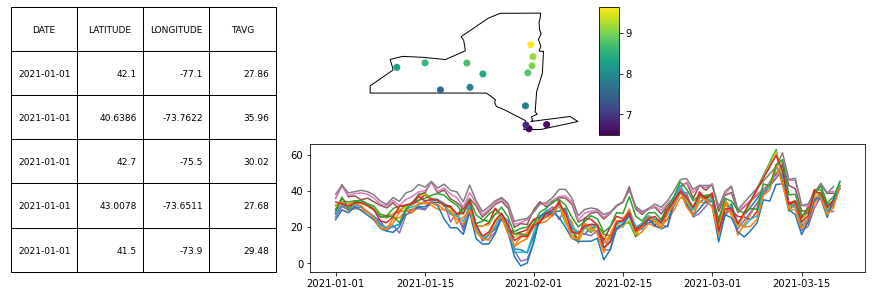

In [42]:
fig, axd = plt.subplot_mosaic([['table', 'map', '.'],
                               ['table', 'time', 'time']], 
                              constrained_layout=True, figsize=(12,4))
table(axd['table'], cellText=dfs.astype('str').values, colLabels=dfs.columns, fontsize=12, bbox=(0, 0, 1, 1))
axd['table'].set(xticks=[], yticks=[], aspect='equal')
for name, df in ny.groupby(['NAME']):
    axd['time'].plot('DATE', 'TAVG', data=df, label=name)

nystate[nystate['postal'].str.match('NY')].plot(ax=axd['map'], facecolor='white', edgecolor='k')
nygdf.plot('TAVG', ax=axd['map'], legend=True)
axd['map'].set_aspect('equal')
axd['map'].axis('off')
fig.savefig(slide_path/"viz_same.png")



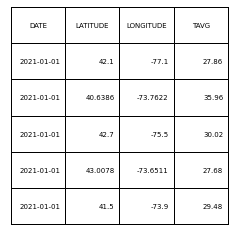

In [43]:
fig, ax = plt.subplots()
table(ax, cellText=dfs.astype('str').values, colLabels=dfs.columns, fontsize=12, bbox=(0, 0, 1, 1))
ax.set(xticks=[], yticks=[], aspect='equal')
fig.savefig(slide_path/"table.png", bbox_inches='tight')